In [16]:
dataset_directory = '../dataset'
validation_directory = dataset_directory + '/validation'
train_directory = dataset_directory + '/train'

In [17]:
from keras.utils import image_dataset_from_directory

image_size = (256, 256)

train_dataset = image_dataset_from_directory(
    train_directory,
    label_mode = 'categorical',
    image_size = image_size,
    batch_size = 8,
    shuffle = True
)

validation_dataset = image_dataset_from_directory(
    validation_directory,
    label_mode = 'categorical',
    image_size = image_size,
    batch_size = 8,
    shuffle = True
)

Found 17208 files belonging to 3 classes.
Found 1000 files belonging to 3 classes.


In [18]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [19]:
from keras.applications import ResNet50

base_model = ResNet50 (
    weights = 'imagenet',
    include_top = False,
    input_shape = image_size + (3,)
)

base_model.trainable = False

In [20]:
from keras.models import Sequential
from keras.layers import InputLayer, Rescaling, RandomFlip, RandomRotation, GlobalAveragePooling2D, Flatten, BatchNormalization, Dropout, Dense

model = Sequential (
    [
        InputLayer(input_shape = image_size + (3,)),

        Rescaling(1./255),
        RandomFlip('horizontal_and_vertical'),
        RandomRotation(factor=0.4, fill_mode='wrap'),

        base_model,

        GlobalAveragePooling2D(),
        Flatten(),

        Dense(64, activation='elu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(64, activation='elu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(3, activation='softmax')
    ]
)

In [21]:
from keras.optimizers import Adam

model.compile (
    optimizer = Adam(),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

In [22]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath = '../models/res-net-50-model.keras',
    monitor ='val_categorical_accuracy',
    verbose = True,
    save_best_only = True,
    save_weights_only=False,
    mode = 'max'
)

In [23]:
history = model.fit(
    train_dataset,
    epochs = 5,
    validation_data = validation_dataset,
    callbacks = [checkpoint]
)

Epoch 1/5


2151/2151 [==============================] - ETA: 0s - loss: 0.5548 - categorical_accuracy: 0.7750
Epoch 1: val_categorical_accuracy improved from -inf to 0.55900, saving model to ../models\res-net-50-model.keras
2151/2151 [==============================] - 261s 117ms/step - loss: 0.5548 - categorical_accuracy: 0.7750 - val_loss: 1.9013 - val_categorical_accuracy: 0.5590
Epoch 2/5
2151/2151 [==============================] - ETA: 0s - loss: 0.4457 - categorical_accuracy: 0.8207
Epoch 2: val_categorical_accuracy did not improve from 0.55900
2151/2151 [==============================] - 257s 119ms/step - loss: 0.4457 - categorical_accuracy: 0.8207 - val_loss: 7.4105 - val_categorical_accuracy: 0.3340
Epoch 3/5
2151/2151 [==============================] - ETA: 0s - loss: 0.4286 - categorical_accuracy: 0.8308
Epoch 3: val_categorical_accuracy did not improve from 0.55900
2151/2151 [==============================] - 243s 113ms/step - loss: 0.4286 - categorical_accuracy: 0.8308 - val_loss: 1.

In [24]:
from keras.models import load_model

model = load_model('../models/res-net-50-model.keras')

In [25]:
start_tunning_at = len(base_model.layers) - int(0.3 * len(base_model.layers))

print(f"Number of layers in the base model: {len(base_model.layers)}")
print(f"Number of layers to be fine-tuned: {len(base_model.layers) - start_tunning_at}")

Number of layers in the base model: 175
Number of layers to be fine-tuned: 52


In [26]:
for layer in base_model.layers[start_tunning_at:]:
    layer.trainable = True

In [27]:
from keras.optimizers import Adam

model.compile (
    optimizer = Adam(),
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy']
)

In [28]:
history = model.fit (
    train_dataset,
    epochs = 30,
    validation_data = validation_dataset,
    callbacks = [checkpoint]
)

Epoch 1/30
2151/2151 [==============================] - ETA: 0s - loss: 0.4653 - categorical_accuracy: 0.8162
Epoch 1: val_categorical_accuracy did not improve from 0.55900
2151/2151 [==============================] - 266s 120ms/step - loss: 0.4653 - categorical_accuracy: 0.8162 - val_loss: 1.6671 - val_categorical_accuracy: 0.5490
Epoch 2/30
2151/2151 [==============================] - ETA: 0s - loss: 0.4227 - categorical_accuracy: 0.8334
Epoch 2: val_categorical_accuracy did not improve from 0.55900
2151/2151 [==============================] - 251s 116ms/step - loss: 0.4227 - categorical_accuracy: 0.8334 - val_loss: 10.5433 - val_categorical_accuracy: 0.3340
Epoch 3/30
2151/2151 [==============================] - ETA: 0s - loss: 0.4147 - categorical_accuracy: 0.8387
Epoch 3: val_categorical_accuracy did not improve from 0.55900
2151/2151 [==============================] - 252s 117ms/step - loss: 0.4147 - categorical_accuracy: 0.8387 - val_loss: 3.6903 - val_categorical_accuracy: 0.33

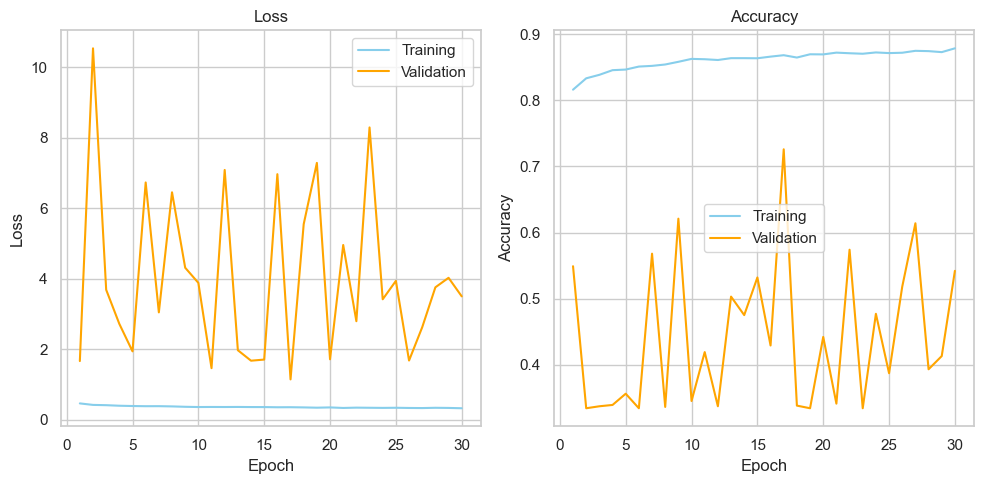

In [29]:
from utils.plot_history import plot_history
plot_history(history)

In [30]:
from keras.models import load_model
model = load_model('../models/res-net-50-model.keras')

1/1 [==============================] - 0s 47ms/step


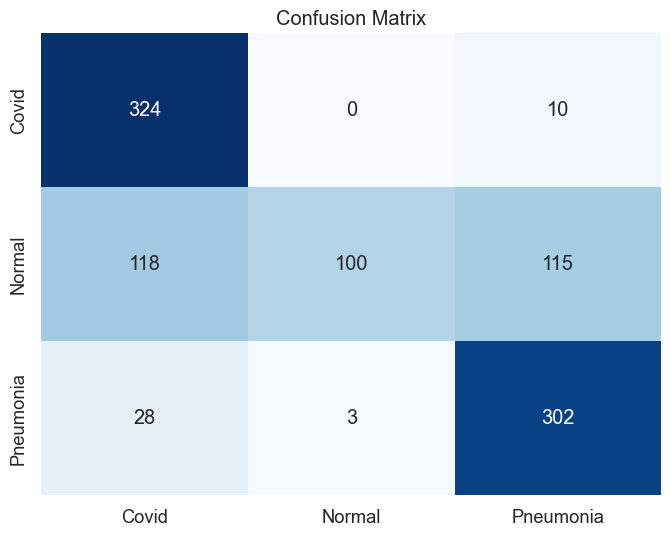

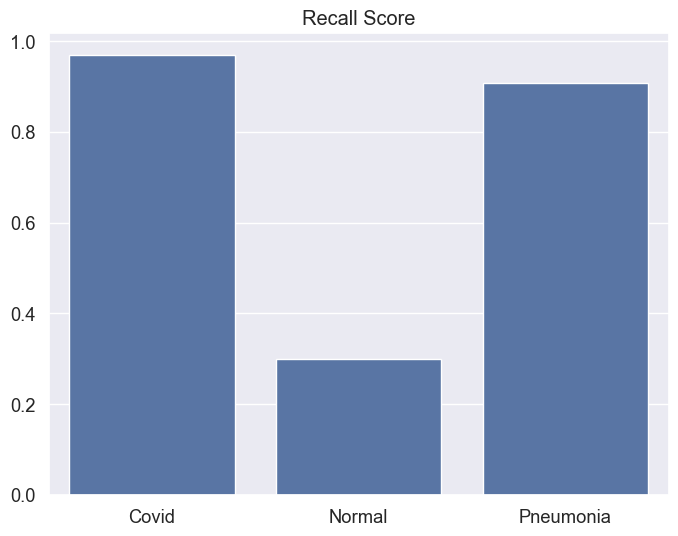

Covid: 0.9701
Normal: 0.3003
Pneumonia: 0.9069


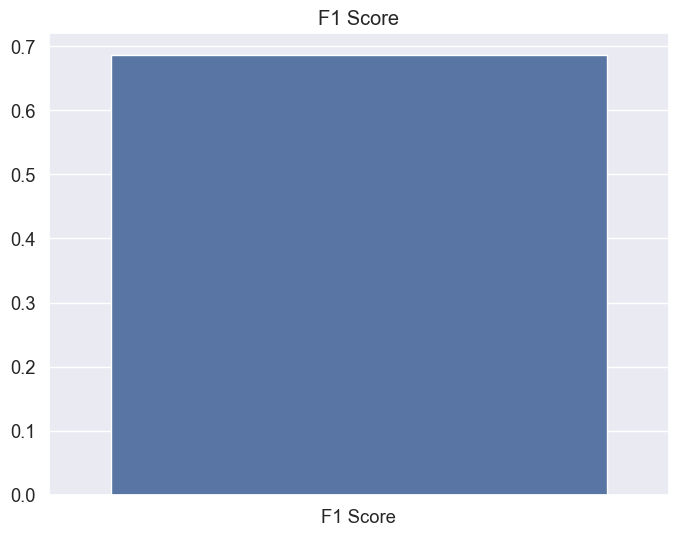

F1-Score: 0.6865


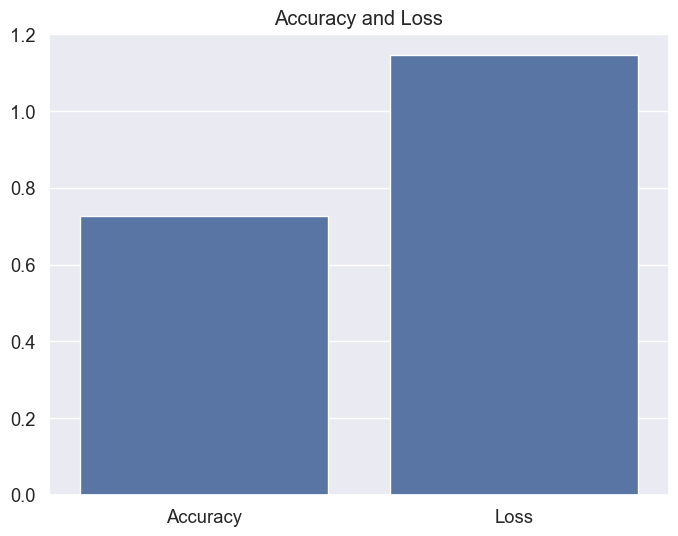

Accuracy: 0.7260 | Loss: 1.1465


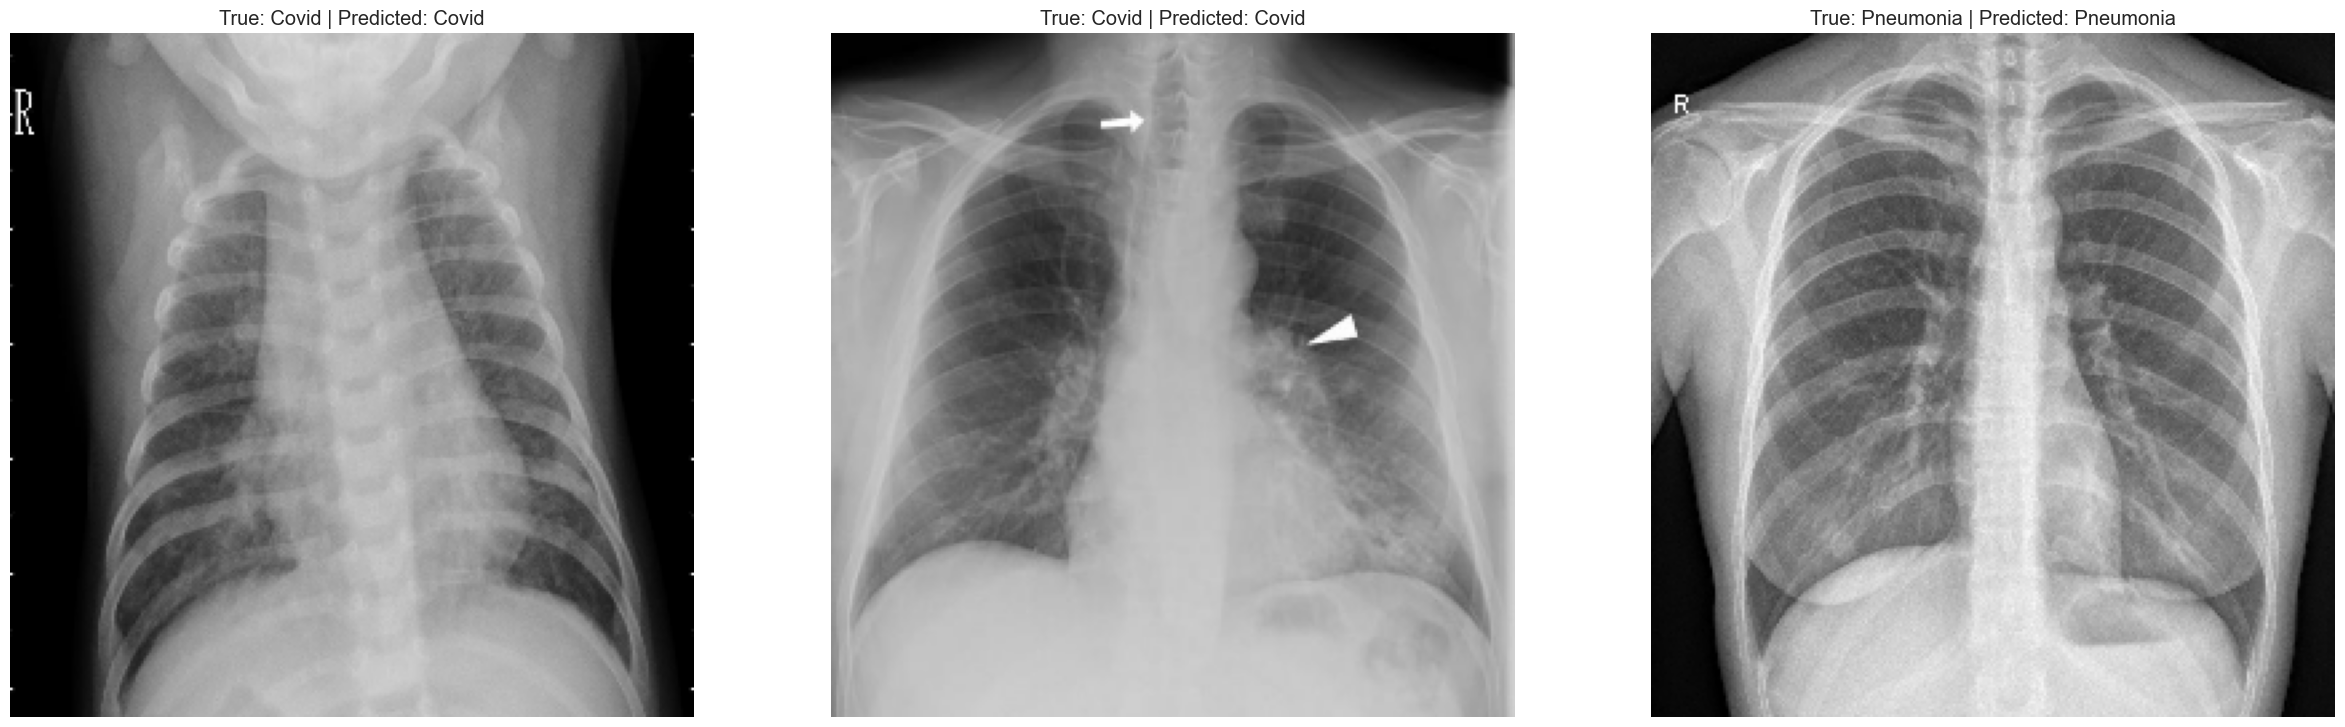

In [31]:
from utils.evaluate_model import evaluate_model 
evaluate_model(model, validation_dataset)